In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
import pickle
import matplotlib.cm as cm

plt.rcParams.update({'font.size': 12})

Stratification from Greace

``` python

depth = 1700.0 # this is up to you of course
z_rho = np.linspace(-depth, 0, 101, endpoint=True) # depending on you vertical discretisation
temp_model = 3.5 + 10.5*np.exp(-6.9/2.0 * (z_rho/depth)**2) + 6.0 * np.exp(15.0 * (z_rho/depth))
# this is basicly composit profile of gaussian + exponential
sal_model = 34.8+ 1.5*np.exp(2.0 * (z_rho/depth))

```

In [2]:
temp_1000 = {}
i_level = 1000
tolerance = 10

for y in range(2011,2020):
    if y == 2018:
        # just realized that 2018  at 1000m doesn't make sense at all!
        continue
        
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        
        depth_y = list(nc['DEPTH'][:])
        level_label = None
        
        for d_i in range(i_level - tolerance, i_level + tolerance):
            if d_i in depth_y:
                level_label = str(d_i)
                
        try:
            temp_1000[y] = np.array(nc[level_label]['TEMP'][:])
        except:
            print(f'{y} has no {i_level}m ± {tolerance}m level')

In [3]:
temp_1000

{2011: array([8.1119, 8.0381, 8.0143, ..., 7.9026, 7.9058, 7.909 ], dtype=float32),
 2012: array([6.5904, 6.608 , 6.6158, ..., 7.3218, 7.3372, 7.3276], dtype=float32),
 2013: array([7.8565, 7.8519, 7.8685, ..., 7.9074, 7.8891, 7.8852], dtype=float32),
 2014: array([7.8775, 7.8766, 7.9065, ..., 7.8893, 7.8688, 7.8771], dtype=float32),
 2015: array([8.1245, 8.1021, 8.0555, ..., 8.4259, 8.3306, 8.3104], dtype=float32),
 2016: array([7.799 , 7.9511, 7.9251, ..., 7.6476, 7.6069, 7.5949], dtype=float32),
 2017: array([7.7261, 7.723 , 7.7199, ..., 8.4296, 8.4194, 8.2836], dtype=float32),
 2019: array([8.3613, 8.3541, 8.2658, ..., 7.4541, 7.4632, 7.4226], dtype=float32)}

In [4]:
temp_1700 = {}
i_level = 1688
tolerance = 5

for y in range(2011,2020):
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        
        depth_y = list(nc['DEPTH'][:])
        level_label = None
        
        for d_i in range(i_level - tolerance, i_level + tolerance):
            if d_i in depth_y:
                level_label = str(d_i)
                
        try:
            temp_1700[y] = np.array(nc[level_label]['TEMP'][:])
        except:
            print(f'{y} has no {i_level}m ± {tolerance}m level')


2014 has no 1688m ± 5m level


In [5]:
temp_1700

{2011: array([4.4204, 4.4258, 4.428 , ..., 4.3456, 4.3384, 4.318 ], dtype=float32),
 2012: array([4.4165, 4.4151, 4.4189, ..., 4.4861, 4.4947, 4.494 ], dtype=float32),
 2013: array([4.3995, 4.3871, 4.3871, ..., 4.5911, 4.588 , 4.5942], dtype=float32),
 2015: array([4.6432, 4.6157, 4.6433, ..., 4.5086, 4.5271, 4.5331], dtype=float32),
 2016: array([4.5241, 4.5338, 4.5778, ..., 4.4261, 4.417 , 4.4082], dtype=float32),
 2017: array([4.542 , 4.5474, 4.5451, ..., 4.5723, 4.5748, 4.5753], dtype=float32),
 2018: array([4.4852, 4.5156, 4.4861, ..., 4.5324, 4.5331, 4.5608], dtype=float32),
 2019: array([4.6146, 4.6195, 4.6333, ..., 4.5684, 4.6047, 4.6171], dtype=float32)}

In [7]:
plt.figure(figsize=(10,6))

year = 2015
# for year in temp_1700:
#     temp = temp_1700[2011]
if year == 2011:
    dt = 180/(3600*24) # 2011 has a period of 180s
else:
    dt = 360/(3600*24) # convert to days days! the rest is 360s

windows = np.array([2, 10, 100])/dt
#windows = [500, 1500, 10000]
    
freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0], noverlap=0.15)
ind, = np.where(freq >= 1e1)
plt.loglog(freq[ind], psd[ind], label=year)

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[1], noverlap=0.15)
ind, = np.where(((freq < 1e1) & (freq >= 1e0)))
plt.loglog(freq[ind], psd[ind])

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[2], noverlap=0.15)
ind, = np.where(((freq < 1e0) & (freq >= 1e-1)))
plt.loglog(freq[ind], psd[ind])

# freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=10000, noverlap=0.15)
freq, psd = sg.periodogram(temp, fs=1./dt)
ind, = np.where((freq < 1e-1))
plt.loglog(freq[ind], psd[ind])

# add typical frequencies
week = 1./7 # yeah, weekly freq.
plt.axvline(week, color='k',alpha=0.5, ls='--')

month = 1./30 # yeah, monthly freq.
plt.axvline(month, color='k',alpha=0.5, ls='--')

yearly = 1./365 # yeah, annual freq.
plt.axvline(yearly, color='k',alpha=0.5, ls='--')



lat = 37 + .17/.6
f = 2*Ω*np.sin(lat*np.pi/180) # coriolis frequency # wher§e is the angular velocity?
print(f'coriolis = {f}')
plt.axvline(f,color='k',alpha=0.5, ls='--')

M2 = 24/12.42# 1/(12.42*3600) # M2
print(f'M2 = {M2}')
plt.axvline(M2,color='k',alpha=0.5, ls='--')

plt.grid(True)
plt.ylim(1e-7, psd.max())
plt.xlabel('Frequency (days $^{-1}$)')
plt.ylabel(r'Power Spectral Density (Temperature)')
#plt.title('Temperature 1700m')
plt.legend()

NameError: name 'temp' is not defined

<Figure size 720x432 with 0 Axes>

## BVF

In [8]:
with open('../support_data/bvs_lucky.pkl', 'rb') as f:
    ambient_stratification = pickle.load(f)
    
z = ambient_stratification['z']
bvf = ambient_stratification['BVF']

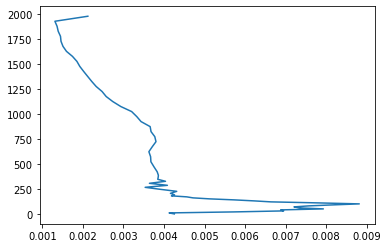

In [9]:
plt.plot(bvf, z)

In [10]:
jj = np.where(z == 1025)
print(bvf[jj].data[0])
bvf_lucky_1000 = bvf[jj].data[0]*3600*24 #day^-1 
bvf_lucky_1000

0.0032020476471068707


276.6569167100336

In [11]:
jj = np.where(z == 1725)
print(bvf[jj].data[0])
bvf_lucky_1700 = bvf[jj].data[0]*3600*24 #day^-1 
bvf_lucky_1700

0.0014599584126140507


126.14040684985399

In [12]:
2e0

2.0

## Welch's segments
### 1700m SBE (6 min period)

In [17]:
lat = 37 + .17/.6
f = 2*np.sin(lat*np.pi/180)
M2 = 24/12.42# 1/(12.42*3600) # M2
S2 = 2
M4 = 24/6.21
week = 1./7 # yeah, weekly freq.
month = 1./30 # yeah, monthly freq.
yearly = 1./365 # yeah, annual freq.

upper_tick_locations = np.array([bvf_lucky_1700, M2, M4, f, week, month, yearly])
upper_tick_labels = ['N', 'M2', 'M4', 'f', 'week', 'month', 'year']


### Methodology plot

In [42]:
w = list(windows)

In [47]:
w.sort()

In [48]:
w

[0.5, 2.0, 10.0, 35.0, 49.0]

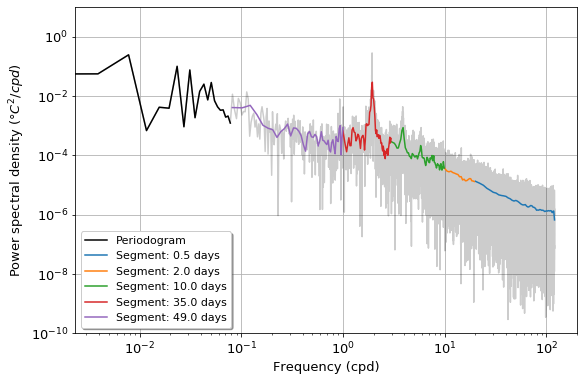

In [57]:
plt.rcParams.update({'font.size': 13})

year = 2015
temp = temp_1700[2015]
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#windows = np.array([2, 10, 35, 49])
#lims = [10, 3, 1, 0.08]

windows = np.array([0.5, 2.0, 10.0, 35.0, 49.0])# the size of the windows in days/dt
lims = [20, 10, 3, 1, 0.08] #[0.08, 1, 3, 10, 20]

if year == 2011:
    dt = 180/(3600*24) # 2011 has a period of 180s
else:
    dt = 360/(3600*24) # convert to days days! the rest is 360s

freq, psd = sg.periodogram(temp, fs=1./dt)
#ind, = np.where(((freq >= 1e-3) & (freq < 1e0) ))
ax1.loglog(freq, psd, c='k', alpha=0.2)
ind, = np.where(freq < lims[-1])
ax1.loglog(freq[ind], psd[ind], alpha=1, c='k', label="Periodogram")

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0]/dt, noverlap=0.15)
ind, = np.where(freq >= lims[0])
ax1.loglog(freq[ind], psd[ind], label = f'Segment: {windows[0]} days')
#ax2.loglog(freq[ind], psd[ind], alpha=0)

for i in range(1,len(lims)):
    freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[i]/dt, noverlap=0.15)
    ind, = np.where(((freq >= lims[i]) & (freq < lims[i-1])))
    ax1.loglog(freq[ind], psd[ind], label = f'Segment: {windows[i]} days')
    #ax2.loglog(freq[ind], psd[ind], alpha=0)

# for typical_freq in upper_tick_locations:
#     ax1.axvline(typical_freq, color='k', alpha=0.5, ls='--')

ax1.grid()
plt.ylim(1e-7, psd.max())
ax1.set_xlabel('Frequency (cpd)')
ax1.set_ylabel(r'Power spectral density ($\degree C^2/cpd$)')
ax1.set_ylim(1e-10, 1e1)
#ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks(upper_tick_locations)
# ax2.set_xticklabels(upper_tick_labels)
ax1.legend(loc='lower left', shadow=True, fontsize=11)
plt.savefig(f'../figures/report_figures/methods/welchs_segments')

### 1000m SBE (6 min period)

In [17]:
lat = 37 + .17/.6
sbe = (3600*24)/360
f = 2*np.sin(lat*np.pi/180)
M2 = 24/12.42# 1/(12.42*3600) # M2
S2 = 2
M4 = 24/6.21
M6 = 24/4.14
week = 1./7 # yeah, weekly freq.
month = 1./30 # yeah, monthly freq.
yearly = 1./365 # yeah, annual freq.

upper_tick_locations = np.array([bvf_lucky_1000, M2, M4, M6, f, week, month, yearly])
upper_tick_labels = ['N', 'M2', 'M4', 'M6', 'f', 'week', 'month', 'year']

In [18]:
bvf_lucky_1000

276.6569167100336

In [19]:
360/(3600*24)

0.004166666666666667

In [20]:
windows

array([  480.,  2400.,  8400., 11760.])

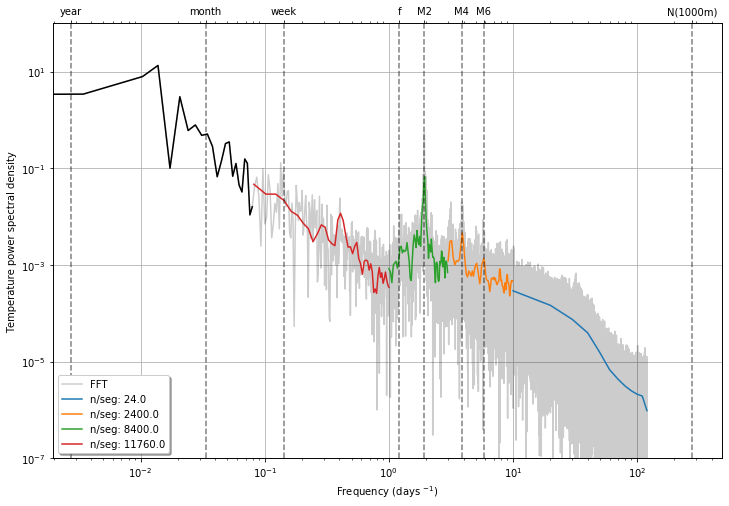

In [21]:
year = 2015
temp = temp_1000[2019]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
windows = np.array([0.1, 10, 35, 49])/dt
lims = [10, 3, 1, 0.08]

if year == 2011:
    dt = 180/(3600*24) # 2011 has a period of 180s
else:
    dt = 360/(3600*24) # convert to days days! the rest is 360s

freq, psd = sg.periodogram(temp, fs=1./dt)
#ind, = np.where(((freq >= 1e-3) & (freq < 1e0) ))
ax1.loglog(freq, psd, label='FFT', c='k', alpha=0.2)
ind, = np.where(freq < lims[-1])
ax2.loglog(freq[ind], psd[ind], alpha=1, c='k', label="FFT")

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0], noverlap=0.15)
ind, = np.where(freq >= lims[0])
ax1.loglog(freq[ind], psd[ind], label = f'n/seg: {windows[0]}')
ax2.loglog(freq[ind], psd[ind], alpha=0)

for i in range(1,len(lims)):
    freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[i], noverlap=0.15)
    ind, = np.where(((freq >= lims[i]) & (freq < lims[i-1])))
    ax1.loglog(freq[ind], psd[ind], label = f'n/seg: {windows[i]}')
    ax2.loglog(freq[ind], psd[ind], alpha=0)

for typical_freq in upper_tick_locations:
    ax1.axvline(typical_freq, color='k', alpha=0.5, ls='--')

ax1.grid()
ax1.set_xlabel('Frequency (days $^{-1}$)')
ax1.set_ylabel(r'Temperature power spectral density')
ax1.set_ylim(1e-7, 1e2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(upper_tick_locations)
ax2.set_xticklabels(upper_tick_labels)
ax1.legend(loc='lower left', shadow=True)

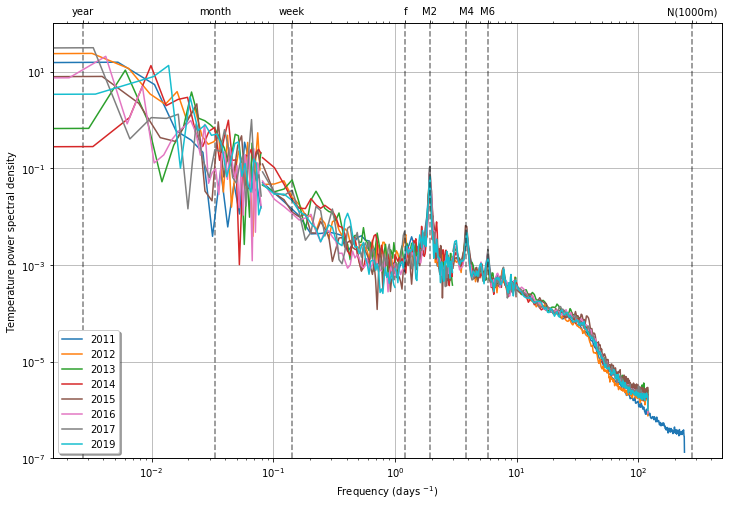

In [22]:
x_colors = np.linspace(0,1, 9)
colors = cm.get_cmap('tab10')(x_colors)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
windows = np.array([2, 10, 35, 49])/dt
lims = [10, 3, 1, 0.08]

for l, year in enumerate(range(2011, 2020)):

    if year == 2011:
        dt = 180/(3600*24) # 2011 has a period of 180s
    elif year == 2018:
        continue
    else:
        dt = 360/(3600*24) # convert to days days! the rest is 360s
    
    temp = temp_1000[year]
    freq, psd = sg.periodogram(temp, fs=1./dt)
    ind, = np.where(freq < lims[-1])
    ax2.loglog(freq[ind], psd[ind], alpha=1, c=colors[l])

    freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0], noverlap=0.15)
    ind, = np.where(freq >= lims[0])
    ax1.loglog(freq[ind], psd[ind], c=colors[l], label=year)
    ax2.loglog(freq[ind], psd[ind], alpha=0)

    for i in range(1,len(lims)):
        freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[i], noverlap=0.15)
        ind, = np.where(((freq >= lims[i]) & (freq < lims[i-1])))
        ax1.loglog(freq[ind], psd[ind], c=colors[l])
        #ax2.loglog(freq[ind], psd[ind], alpha=0)

for typical_freq in upper_tick_locations:
    ax1.axvline(typical_freq, color='k', alpha=0.5, ls='--')

ax1.grid()
ax1.set_xlabel('Frequency (days $^{-1}$)')
ax1.set_ylabel(r'Temperature power spectral density')
ax1.set_ylim(1e-7, 1e2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(upper_tick_locations)
ax2.set_xticklabels(upper_tick_labels)
ax1.legend(loc='lower left', shadow=True)
#### SAVE THIS ####

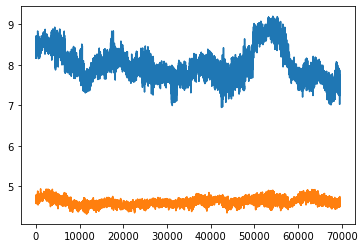

In [24]:
plt.plot(temp_1000[2019])
plt.plot(temp_1700[2019])

In [23]:
for year in range(2011, 2020):
averages = {}

#year = 2015
temp = temp_1000[year]
windows = np.array([2, 10, 35, 49])/dt
lims = [10, 3, 1, 0.08]

if year == 2011:
    dt = 180/(3600*24) # 2011 has a period of 180s
else:
    dt = 360/(3600*24) # convert to days days! the rest is 360s

freq, psd = sg.periodogram(temp, fs=1./dt)
#ind, = np.where(((freq >= 1e-3) & (freq < 1e0) ))
#ax1.loglog(freq, psd, label='FFT', c='k', alpha=0.2)
ind, = np.where(freq < lims[-1])
ax2.loglog(freq[ind], psd[ind], alpha=1, c='k', label="FFT")

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0], noverlap=0.15)
ind, = np.where(freq >= lims[0])
ax1.loglog(freq[ind], psd[ind], label = f'n/seg: {windows[0]}')
ax2.loglog(freq[ind], psd[ind], alpha=0)

for i in range(1,len(lims)):
    freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[i], noverlap=0.15)
    ind, = np.where(((freq >= lims[i]) & (freq < lims[i-1])))
    ax1.loglog(freq[ind], psd[ind], label = f'n/seg: {windows[i]}')
    ax2.loglog(freq[ind], psd[ind], alpha=0)

for typical_freq in upper_tick_locations:
    ax1.axvline(typical_freq, color='k', alpha=0.5, ls='--')

ax1.grid()
ax1.set_xlabel('Frequency (days $^{-1}$)')
ax1.set_ylabel(r'Temperature power spectral density')
ax1.set_ylim(1e-7, 1e2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(upper_tick_locations)
ax2.set_xticklabels(upper_tick_labels)
ax1.legend(loc='lower left', shadow=True)

IndentationError: expected an indented block (<ipython-input-23-ed35959cc53e>, line 2)

## Computoing averages of PSD 

##### periodoram method

In [ ]:
All = pd.DataFrame()
windows = np.array([2, 10, 35, 49])/dt
lims = [10, 3, 1, 0.06]

for year in range(2011, 2020):
    if year == 2011:
        dt = 180/(3600*24) # 2011 has a period of 180s
    elif year == 2018:
        continue
    else:
        dt = 360/(3600*24) # convert to days days! the rest is 360s

    freq1, psd1 = sg.periodogram(temp_1000[year], fs=1./dt)
    ind, = np.where(freq1 < lims[-1])
    aux = pd.DataFrame({f'freq_{year}': freq1[ind], f'psd_{year}': psd1[ind]})
    All = pd.concat([All, aux], axis=1, sort=False)
drop_labels = [f'freq_{year}' for year in range(2011, 2020)]
drop_labels.pop(5)
drop_labels.pop(6)
All.set_index('freq_2016', inplace=True)
All.drop(drop_labels, axis=1, inplace=True)
All['avg'] = All.mean(axis=1)
All['std'] = All.std(axis=1)

In [ ]:
plt.loglog(All.index, All['avg'] )

In [ ]:
upper_tick_locations = np.array([bvf_lucky_1000, M2, M4, M6, f, week, month, yearly])
upper_tick_labels = ['N(1000m)', 'M2', 'M4', 'M6', 'f', 'week', 'month', 'year']

year = 2019
temp = temp_1000[year]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
windows = np.array([2, 10, 35, 60, 150])/dt
lims = [10, 3, 1, 0.2, 0.06]

if year == 2011:
    dt = 180/(3600*24) # 2011 has a period of 180s
else:
    dt = 360/(3600*24) # convert to days days! the rest is 360s

freq, psd = sg.periodogram(temp, fs=1./dt)
#ind, = np.where(((freq >= 1e-3) & (freq < 1e0) ))
ax1.loglog(freq, psd, c='k', alpha=0.2, label="FFT")
ind, = np.where(freq < lims[-1])
ax1.loglog(All.index, All['avg'], alpha=1, c='k', label="FFT_mean")

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0], noverlap=0.15)
ind, = np.where(freq >= lims[0])
ax1.loglog(freq[ind], psd[ind], label = f'Welch: {windows[0]*dt:0.0f} days')
ax2.loglog(freq[ind], psd[ind], alpha=0)

for i in range(1,len(lims)):
    freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[i], noverlap=0.15)
    ind, = np.where(((freq >= lims[i]) & (freq < lims[i-1])))
    ax1.loglog(freq[ind], psd[ind], label = f'Welch: {windows[i]*dt:0.0f} days')
    ax2.loglog(freq[ind], psd[ind], alpha=0)

for typical_freq in upper_tick_locations:
    ax1.axvline(typical_freq, color='k', alpha=0.5, ls='--')

ax1.grid()
ax1.set_xlabel('Frequency (days $^{-1}$)')
ax1.set_ylabel(r'Temperature power spectral density (SBE -1000m)')
ax1.set_ylim(1e-7, 1e2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(upper_tick_locations)
ax2.set_xticklabels(upper_tick_labels)
ax1.legend(loc='lower left', shadow=True)
#ax1.text(100, 1.1e-7, 'SBE -1000m', fontsize= 14, horizontalalignment='right')
plt.savefig(f'figures/PSD_temp_sbe_1000_{year}', facecolor=(1,0,0,0))

#### 1700m

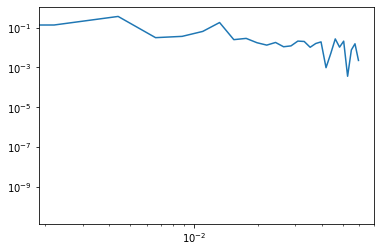

In [25]:
All = pd.DataFrame()
windows = np.array([2, 10, 35, 49])/dt
lims = [10, 3, 1, 0.06]

for year in range(2015, 2020):
    if year == 2011:
        dt = 180/(3600*24) # 2011 has a period of 180s
    elif year == 2018:
        continue
    else:
        dt = 360/(3600*24) # convert to days days! the rest is 360s

    freq1, psd1 = sg.periodogram(temp_1700[year], fs=1./dt)
    ind, = np.where(freq1 < lims[-1])
    aux = pd.DataFrame({f'freq_{year}': freq1[ind], f'psd_{year}': psd1[ind]})
    All = pd.concat([All, aux], axis=1, sort=False)
    
drop_labels = [f'freq_{year}' for year in range(2015, 2020)]
drop_labels.pop(1)
drop_labels.pop(2)
All.set_index('freq_2016', inplace=True)

All.drop(drop_labels, axis=1, inplace=True)
All['avg'] = All.mean(axis=1)
All['std'] = All.std(axis=1)
plt.loglog(All.index, All['avg'] )

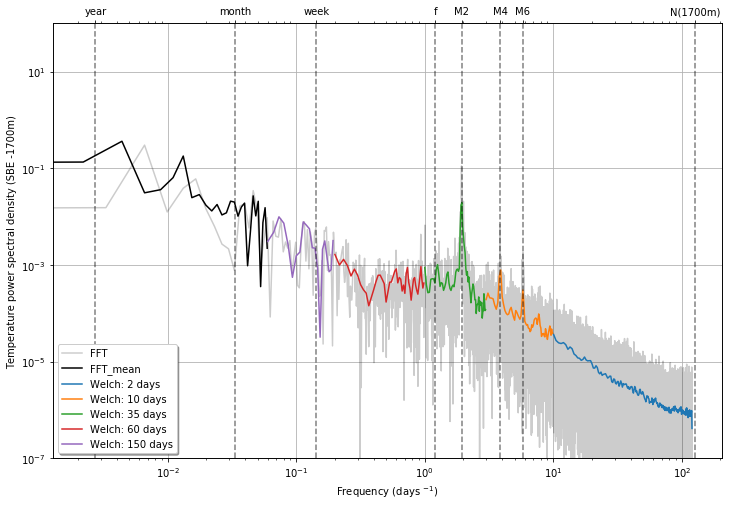

In [26]:
upper_tick_locations = np.array([bvf_lucky_1700, M2, M4, M6, f, week, month, yearly])
upper_tick_labels = ['N(1700m)', 'M2', 'M4', 'M6', 'f', 'week', 'month', 'year']

year = 2017
temp = temp_1700[year]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
windows = np.array([2, 10, 35, 60, 150])/dt
lims = [10, 3, 1, 0.2, 0.06]

if year == 2011:
    dt = 180/(3600*24) # 2011 has a period of 180s
else:
    dt = 360/(3600*24) # convert to days days! the rest is 360s

freq, psd = sg.periodogram(temp, fs=1./dt)
#ind, = np.where(((freq >= 1e-3) & (freq < 1e0) ))
ax1.loglog(freq, psd, c='k', alpha=0.2, label="FFT")
ind, = np.where(freq < lims[-1])
ax1.loglog(All.index, All['avg'], alpha=1, c='k', label="FFT_mean")

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0], noverlap=0.15)
ind, = np.where(freq >= lims[0])
ax1.loglog(freq[ind], psd[ind], label = f'Welch: {windows[0]*dt:0.0f} days')
ax2.loglog(freq[ind], psd[ind], alpha=0)

for i in range(1,len(lims)):
    freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[i], noverlap=0.15)
    ind, = np.where(((freq >= lims[i]) & (freq < lims[i-1])))
    ax1.loglog(freq[ind], psd[ind], label = f'Welch: {windows[i]*dt:0.0f} days')
    ax2.loglog(freq[ind], psd[ind], alpha=0)

for typical_freq in upper_tick_locations:
    ax1.axvline(typical_freq, color='k', alpha=0.5, ls='--')

ax1.grid()
ax1.set_xlabel('Frequency (days $^{-1}$)')
ax1.set_ylabel(r'Temperature power spectral density (SBE -1700m)')
ax1.set_ylim(1e-7, 1e2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(upper_tick_locations)
ax2.set_xticklabels(upper_tick_labels)
ax1.legend(loc='lower left', shadow=True)
#ax1.text(100, 1.1e-7, 'SBE -1000m', fontsize= 14, horizontalalignment='right')
plt.savefig(f'figures/PSD_temp_sbe_1700_{year}', facecolor=(1,0,0,0))

### 1000 RBR

In [27]:
with open('../support_data/depth_corrections', 'rb') as f:
    depths_corrections = pickle.load(f)

In [28]:
depths_corrections[2015]

0.40370765203715564

In [ ]:
rbr_1700 = {}
rbr = {}

for year in range(2019,2020):
    with Dataset(f'../netcdf/{year}/rbr.nc', 'r') as nc:

        n_depths = len(nc['DEPTH'][:])
        depth_rbr = np.array(nc['DEPTH'][:])
        print(year, max(-depth_rbr + depths_corrections[year]), min(depth_rbr), depth_rbr)
        rbr_1700[year] = temp = np.array(nc['TEMP'][:][:, -1])
        print(np.array(nc['TEMP'][:]).shape)

TypeError: '<' not supported between instances of '_io.BufferedReader' and 'float'

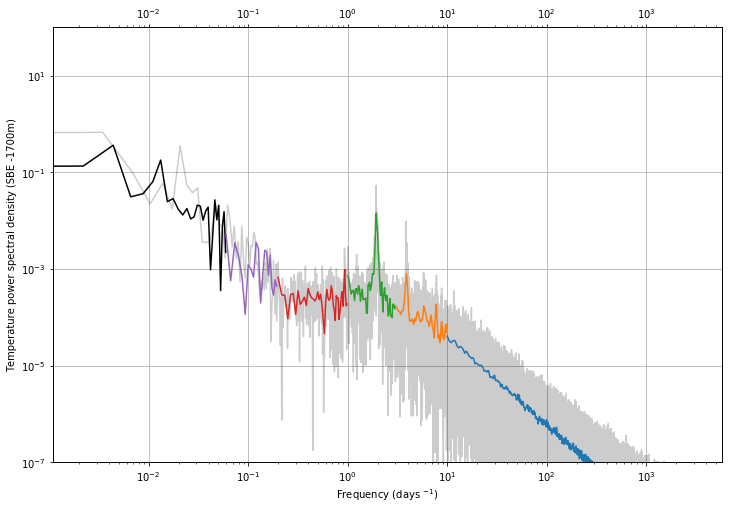

In [30]:
upper_tick_locations = np.array([bvf_lucky_1700, M2, M4, M6, f, week, month, yearly])
upper_tick_labels = ['N(1700m)', 'M2', 'M4', 'M6', 'f', 'week', 'month', 'year']

year = 2019
temp = rbr_1700[year]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
dt = 15/(3600*24)
windows = np.array([2, 10, 35, 60, 150])/dt
lims = [10, 3, 1, 0.2, 0.06]

freq, psd = sg.periodogram(temp, fs=1./dt)
#ind, = np.where(((freq >= 1e-3) & (freq < 1e0) ))
ax1.loglog(freq, psd, c='k', alpha=0.2, label="FFT")
ind, = np.where(freq < lims[-1])
ax1.loglog(All.index, All['avg'], alpha=1, c='k', label="FFT_mean")

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0], noverlap=0.15)
ind, = np.where(freq >= lims[0])
ax1.loglog(freq[ind], psd[ind], label = f'Welch: {windows[0]*dt:0.0f} days')
ax2.loglog(freq[ind], psd[ind], alpha=0)

for i in range(1,len(lims)):
    freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[i], noverlap=0.15)
    ind, = np.where(((freq >= lims[i]) & (freq < lims[i-1])))
    ax1.loglog(freq[ind], psd[ind], label = f'Welch: {windows[i]*dt:0.0f} days')
    ax2.loglog(freq[ind], psd[ind], alpha=0)

# for typical_freq in upper_tick_locations:
#     ax1.axvline(typical_freq, color='k', alpha=0.5, ls='--')

ax1.grid()
ax1.set_xlabel('Frequency (days $^{-1}$)')
ax1.set_ylabel(r'Temperature power spectral density (SBE -1700m)')
ax1.set_ylim(1e-7, 1e2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(upper_tick_locations)
ax2.set_xticklabels(upper_tick_labels)
ax1.legend(loc='lower left', shadow=True)
#ax1.text(100, 1.1e-7, 'SBE -1000m', fontsize= 14, horizontalalignment='right')
plt.savefig(f'figures/PSD_temp_sbe_1700_{year}', facecolor=(1,0,0,0))

In [ ]:
upper_tick_locations = np.array([bvf_lucky_1700, M2, f, week, month, yearly])
upper_tick_labels = ['N(1700m)', 'M2', 'f', 'week', 'month', 'year']

year = 2019
temp = rbr_1700[year]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
dt = 15/(3600*24)
windows = np.array([0.1, 2, 10, 35, 49])/dt
lims = [100, 10, 3, 1, 0.08]

freq, psd = sg.periodogram(temp, fs=1./dt)
#ax1.loglog(freq, psd, label='FFT', c='k', alpha=0.2)
ind, = np.where(freq < lims[-1])
ax1.loglog(freq[ind], psd[ind], alpha=1, c='k', label="FFT")

freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[0], noverlap=0.15)
ind, = np.where(freq >= lims[0])
ax1.loglog(freq[ind], psd[ind], label = f'n/seg: {windows[0]}')
ax2.loglog(freq[ind], psd[ind], alpha=0)

for i in range(1,len(lims)):
    freq, psd = sg.welch(temp, fs=1./dt, window='hanning', nperseg=windows[i], noverlap=0.15)
    ind, = np.where(((freq >= lims[i]) & (freq < lims[i-1])))
    ax1.loglog(freq[ind], psd[ind], label = f'n/seg: {windows[i]}')
    #ax2.loglog(freq[ind], psd[ind], alpha=0)

# for typical_freq in upper_tick_locations:
#     ax1.axvline(typical_freq, color='k', alpha=0.5, ls='--')

ax1.grid()
#plt.ylim(1e-7, psd.max())
# ax1.set_xlabel('Frequency (days $^{-1}$)')
# ax1.set_ylabel(r'Temperature power spectral density')
# #ax1.set_ylim(1e-7, 1e1)
# ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks(upper_tick_locations)
# ax2.set_xticklabels(upper_tick_labels)
# ax1.legend(loc='lower left', shadow=True)

In [ ]:
upper_tick_locations = np.array([bvf_lucky_1000, M2, f, week, month, yearly])
upper_tick_labels = ['N(1000m)', 'M2', 'f', 'week', 'month', 'year']